<a href="https://colab.research.google.com/github/harishjungshahi/Deep-Learning/blob/main/Dropout_Regularization_L1%2CL2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Loading Datasets

In [4]:
df = pd.read_csv('sonar.all-data', header=None)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
22,0.0099,0.0484,0.0299,0.0297,0.0652,0.1077,0.2363,0.2385,0.0075,0.1882,0.1456,0.1892,0.3176,0.1340,0.2169,0.2458,0.2589,0.2786,0.2298,0.0656,0.1441,0.1179,0.1668,0.1783,0.2476,0.2570,0.1036,0.5356,0.7124,0.6291,0.4756,0.6015,0.7208,0.6234,0.5725,0.7523,0.8712,0.9252,0.9709,0.9297,0.8995,0.7911,0.5600,0.2838,0.4407,0.5507,0.4331,0.2905,0.1981,0.0779,0.0396,0.0173,0.0149,0.0115,0.0202,0.0139,0.0029,0.0160,0.0106,0.0134,R
28,0.0100,0.0275,0.0190,0.0371,0.0416,0.0201,0.0314,0.0651,0.1896,0.2668,0.3376,0.3282,0.2432,0.1268,0.1278,0.4441,0.6795,0.7051,0.7966,0.9401,0.9857,0.8193,0.5789,0.6394,0.7043,0.6875,0.4081,0.1811,0.2064,0.3917,0.3791,0.2042,0.2227,0.3341,0.3984,0.5077,0.5534,0.3352,0.2723,0.2278,0.2044,0.1986,0.0835,0.0908,0.1380,0.1948,0.1211,0.0843,0.0589,0.0247,0.0118,0.0088,0.0104,0.0036,0.0088,0.0047,0.0117,0.0020,0.0091,0.0058,R
87,0.0856,0.0454,0.0382,0.0203,0.0385,0.0534,0.2140,0.3110,0.2837,0.2751,0.2707,0.0946,0.1020,0.4519,0.6737,0.6699,0.7066,0.5632,0.3785,0.2721,0.5297,0.7697,0.8643,0.9304,0.9372,0.6247,0.6024,0.6810,0.5047,0.5775,0.4754,0.2400,0.2779,0.1997,0.5305,0.7409,0.7775,0.4424,0.1416,0.3508,0.4482,0.4208,0.3054,0.2235,0.2611,0.2798,0.2392,0.2021,0.1326,0.0358,0.0128,0.0172,0.0138,0.0079,0.0037,0.0051,0.0258,0.0102,0.0037,0.0037,R
59,0.0125,0.0152,0.0218,0.0175,0.0362,0.0696,0.0873,0.0616,0.1252,0.1302,0.0888,0.0500,0.0628,0.1274,0.0801,0.0742,0.2048,0.2950,0.3193,0.4567,0.5959,0.7101,0.8225,0.8425,0.9065,0.9802,1.0000,0.8752,0.7583,0.6616,0.5786,0.5128,0.4776,0.4994,0.5197,0.5071,0.4577,0.3505,0.1845,0.1890,0.1967,0.1041,0.0550,0.0492,0.0622,0.0505,0.0247,0.0219,0.0102,0.0047,0.0019,0.0041,0.0074,0.0030,0.0050,0.0048,0.0017,0.0041,0.0086,0.0058,R
155,0.0211,0.0128,0.0015,0.0450,0.0711,0.1563,0.1518,0.1206,0.1666,0.1345,0.0785,0.0367,0.1227,0.2614,0.4280,0.6122,0.7435,0.8130,0.9006,0.9603,0.9162,0.9140,0.7851,0.5134,0.3439,0.3290,0.2571,0.3685,0.5765,0.6190,0.4613,0.3615,0.4434,0.3864,0.3093,0.2138,0.1112,0.1386,0.1523,0.0996,0.1644,0.1902,0.1313,0.1776,0.2000,0.0765,0.0727,0.0749,0.0449,0.0134,0.0174,0.0117,0.0023,0.0047,0.0049,0.0031,0.0024,0.0039,0.0051,0.0015,M


In [5]:
df.shape

(208, 61)

In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

In [7]:
df[60].value_counts()

,count
60,
M,111
R,97


In [8]:
df[60] = df[60].map({'M':0, 'R':1})
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1


In [9]:
X = df.drop(60, axis=1)
y = df[60]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [11]:
X_train.shape

(156, 60)

In [12]:
y_train.values

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1])

In [13]:
# Convert the split arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [14]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train a Neural Network Without Drop Regularization

In [16]:
class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(60, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 2)        # Final output Layer Without Activation for raw  logits
    )

  def forward(self, x):
    return self.network(x)

In [20]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

Epoch 1/20, Train Loss: 0.6909, Val Loss: 0.6698, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6855, Val Loss: 0.6467, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6632, Val Loss: 0.6485, Val Accuracy: 0.6731
Epoch 4/20, Train Loss: 0.6491, Val Loss: 0.6280, Val Accuracy: 0.6538
Epoch 5/20, Train Loss: 0.6215, Val Loss: 0.5975, Val Accuracy: 0.6538
Epoch 6/20, Train Loss: 0.5950, Val Loss: 0.5687, Val Accuracy: 0.6731
Epoch 7/20, Train Loss: 0.5707, Val Loss: 0.5484, Val Accuracy: 0.7308
Epoch 8/20, Train Loss: 0.5336, Val Loss: 0.5370, Val Accuracy: 0.7308
Epoch 9/20, Train Loss: 0.4959, Val Loss: 0.5216, Val Accuracy: 0.7308
Epoch 10/20, Train Loss: 0.4640, Val Loss: 0.5310, Val Accuracy: 0.7115
Epoch 11/20, Train Loss: 0.4443, Val Loss: 0.5118, Val Accuracy: 0.7115
Epoch 12/20, Train Loss: 0.4180, Val Loss: 0.4897, Val Accuracy: 0.7308
Epoch 13/20, Train Loss: 0.3960, Val Loss: 0.5451, Val Accuracy: 0.7308
Epoch 14/20, Train Loss: 0.3764, Val Loss: 0.4754, Val Accuracy: 0.7500
E

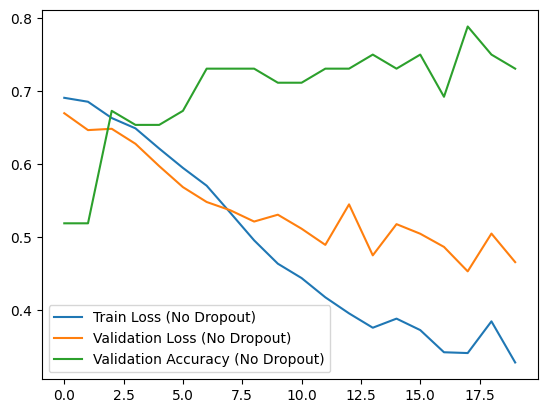

In [22]:
# Initialize and train the model without the dropout
model_without_dropout = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_dropout.parameters(),lr=0.001)

train_losses_no_dropout, val_losses_no_dropout, val_accuracies_no_dropout = train_model(model_without_dropout, train_loader, test_loader, criterion, optimizer, epochs =20)

# plot training and validation loss and accuracy (Without Dropout)
plt.plot(train_losses_no_dropout, label="Train Loss (No Dropout)")
plt.plot(val_losses_no_dropout, label="Validation Loss (No Dropout)")
plt.plot(val_accuracies_no_dropout, label="Validation Accuracy (No Dropout)")
plt.legend()
plt.show()

# Train a Neural Network with a Dropout Regularization

In [24]:
# Model with Dropout using nn.Sequential
class SimpleNNWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout layer after the first ReLU
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout layer after the second ReLU
            nn.Linear(64, 2)  # Final output layer without activation for raw logits
        )

    def forward(self, x):
        return self.network(x)

Epoch 1/20, Train Loss: 0.6896, Val Loss: 0.6784, Val Accuracy: 0.7308
Epoch 2/20, Train Loss: 0.7000, Val Loss: 0.6635, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6875, Val Loss: 0.6551, Val Accuracy: 0.5192
Epoch 4/20, Train Loss: 0.6785, Val Loss: 0.6508, Val Accuracy: 0.5192
Epoch 5/20, Train Loss: 0.6741, Val Loss: 0.6487, Val Accuracy: 0.6154
Epoch 6/20, Train Loss: 0.6646, Val Loss: 0.6403, Val Accuracy: 0.6346
Epoch 7/20, Train Loss: 0.6583, Val Loss: 0.6313, Val Accuracy: 0.6346
Epoch 8/20, Train Loss: 0.6406, Val Loss: 0.6138, Val Accuracy: 0.6154
Epoch 9/20, Train Loss: 0.6415, Val Loss: 0.6056, Val Accuracy: 0.6346
Epoch 10/20, Train Loss: 0.6065, Val Loss: 0.5989, Val Accuracy: 0.7500
Epoch 11/20, Train Loss: 0.6050, Val Loss: 0.5904, Val Accuracy: 0.7885
Epoch 12/20, Train Loss: 0.5685, Val Loss: 0.5627, Val Accuracy: 0.7308
Epoch 13/20, Train Loss: 0.5951, Val Loss: 0.5519, Val Accuracy: 0.7308
Epoch 14/20, Train Loss: 0.5575, Val Loss: 0.5502, Val Accuracy: 0.7692
E

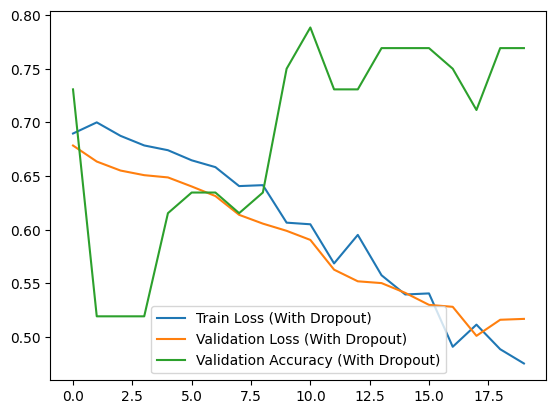

In [25]:
# Initialize and train the model with dropout
model_with_dropout = SimpleNNWithDropout()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.001)

train_losses_with_dropout, val_losses_with_dropout, val_accuracies_with_dropout = train_model(
    model_with_dropout, train_loader, test_loader, criterion, optimizer, epochs=20
)

# Plot training and validation loss and accuracy (With Dropout)
plt.plot(train_losses_with_dropout, label="Train Loss (With Dropout)")
plt.plot(val_losses_with_dropout, label="Validation Loss (With Dropout)")
plt.plot(val_accuracies_with_dropout, label="Validation Accuracy (With Dropout)")
plt.legend()
plt.show()

### Train a Neural Network Without Any Regularization

In [29]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Final output layer without activation for raw logits
        )

    def forward(self, x):
        return self.network(x)

In [30]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

Epoch 1/40, Train Loss: 0.6895, Val Loss: 0.6706, Val Accuracy: 0.5192
Epoch 2/40, Train Loss: 0.6781, Val Loss: 0.6527, Val Accuracy: 0.5192
Epoch 3/40, Train Loss: 0.6626, Val Loss: 0.6464, Val Accuracy: 0.6154
Epoch 4/40, Train Loss: 0.6463, Val Loss: 0.6244, Val Accuracy: 0.6538
Epoch 5/40, Train Loss: 0.6198, Val Loss: 0.5982, Val Accuracy: 0.6538
Epoch 6/40, Train Loss: 0.5960, Val Loss: 0.5761, Val Accuracy: 0.7115
Epoch 7/40, Train Loss: 0.5586, Val Loss: 0.5451, Val Accuracy: 0.7115
Epoch 8/40, Train Loss: 0.5252, Val Loss: 0.5291, Val Accuracy: 0.7115
Epoch 9/40, Train Loss: 0.4944, Val Loss: 0.5426, Val Accuracy: 0.7885
Epoch 10/40, Train Loss: 0.4569, Val Loss: 0.5065, Val Accuracy: 0.6923
Epoch 11/40, Train Loss: 0.4431, Val Loss: 0.4812, Val Accuracy: 0.7115
Epoch 12/40, Train Loss: 0.4020, Val Loss: 0.4935, Val Accuracy: 0.7500
Epoch 13/40, Train Loss: 0.3938, Val Loss: 0.4766, Val Accuracy: 0.7500
Epoch 14/40, Train Loss: 0.4486, Val Loss: 0.6255, Val Accuracy: 0.7500
E

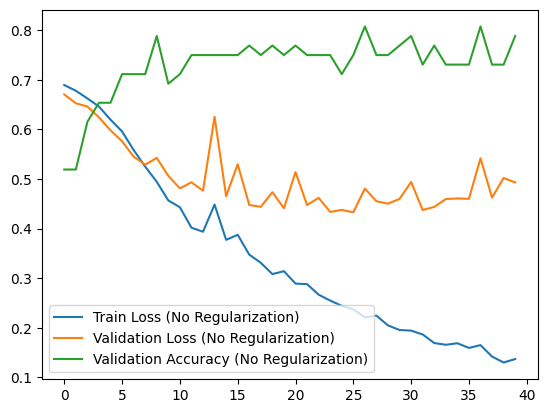

In [31]:
# Initialize and train the model without dropout
model_without_reg = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_reg.parameters(), lr=0.001)

train_losses_no_reg, val_losses_no_reg, val_accuracies_no_reg = train_model(
    model_without_reg, train_loader, test_loader, criterion, optimizer, epochs=40
)

# Plot training and validation loss and accuracy (Without Dropout)
plt.plot(train_losses_no_reg, label="Train Loss (No Regularization)")
plt.plot(val_losses_no_reg, label="Validation Loss (No Regularization)")
plt.plot(val_accuracies_no_reg, label="Validation Accuracy (No Regularization)")
plt.legend()
plt.show()

### Train a Neural Network With L2 Regularization

Epoch 1/40, Train Loss: 0.6959, Val Loss: 0.6808, Val Accuracy: 0.5192
Epoch 2/40, Train Loss: 0.6874, Val Loss: 0.6765, Val Accuracy: 0.5192
Epoch 3/40, Train Loss: 0.6847, Val Loss: 0.6732, Val Accuracy: 0.5192
Epoch 4/40, Train Loss: 0.6848, Val Loss: 0.6700, Val Accuracy: 0.5192
Epoch 5/40, Train Loss: 0.6831, Val Loss: 0.6675, Val Accuracy: 0.5192
Epoch 6/40, Train Loss: 0.6825, Val Loss: 0.6693, Val Accuracy: 0.5192
Epoch 7/40, Train Loss: 0.6815, Val Loss: 0.6690, Val Accuracy: 0.5192
Epoch 8/40, Train Loss: 0.6801, Val Loss: 0.6698, Val Accuracy: 0.5192
Epoch 9/40, Train Loss: 0.6821, Val Loss: 0.6623, Val Accuracy: 0.5192
Epoch 10/40, Train Loss: 0.6797, Val Loss: 0.6688, Val Accuracy: 0.5192
Epoch 11/40, Train Loss: 0.6771, Val Loss: 0.6635, Val Accuracy: 0.5192
Epoch 12/40, Train Loss: 0.6749, Val Loss: 0.6566, Val Accuracy: 0.5192
Epoch 13/40, Train Loss: 0.6725, Val Loss: 0.6545, Val Accuracy: 0.5192
Epoch 14/40, Train Loss: 0.6695, Val Loss: 0.6531, Val Accuracy: 0.5192
E

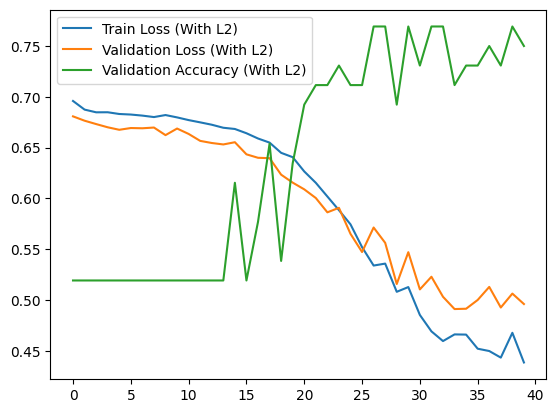

In [32]:
# Initialize and train the model with L2 regularization
model_with_l2 = NeuralNet()
optimizer = optim.Adam(model_with_l2.parameters(), lr=0.001, weight_decay=0.04) # weight decay parameter is used for L2 regularization

train_losses_with_l2, val_losses_with_l2, val_accuracies_with_l2 = train_model(
    model_with_l2, train_loader, test_loader, criterion, optimizer, epochs=40
)

# Plot training and validation loss and accuracy (With Dropout)
plt.plot(train_losses_with_l2, label="Train Loss (With L2)")
plt.plot(val_losses_with_l2, label="Validation Loss (With L2)")
plt.plot(val_accuracies_with_l2, label="Validation Accuracy (With L2)")
plt.legend()
plt.show()